In [1]:
#Load Required Libraries
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
from datetime import datetime
import csv
import seaborn as sns
from matplotlib import rcParams
from wordcloud import WordCloud
import random
import numpy as np
from PIL import Image

In [2]:
with open('../data/aniDB.csv', mode='r', encoding='utf-8') as csv_file:
    csv_reader = csv.DictReader(csv_file)
    
    score = []
    scoreMembers = []

    keyword = "Death Note"
    
    for row in csv_reader:
        if keyword.lower() in row['name'].lower() and row['score'] != "N/A":
            print(row['name'] + " - " + row['type'])
            score.append(float(row['score']))
            scoreMembers.append(int(row['scoreMembers'].replace(',','')))
    print('')
    print('Total Season:',len(score))
    if len(score) != 0:
        print("Avg Score:",round(sum(score) / len(score), 2))
        print("Avg Member:",round(sum(scoreMembers) / len(scoreMembers), 2))


Death Note - TV
Death Note - TV
Death Note: Rewrite - Special
Death Note - TV

Total Season: 4
Avg Score: 8.4
Avg Member: 2094277.5


In [3]:
#Load Data
data = pd.read_csv("../data/aniDB.csv", index_col = 0)
data.head()

name  epNum         producer  \
id                                                      
1     Fushigi no Umi no Nadia   39.0           Gainax   
2       NG Knight Ramune & 40   38.0  Production Reed   
3   Mahou no Angel Sweet Mint   47.0  Production Reed   
4   Idol Tenshi Youkoso Youko   43.0              NaN   
5    Mashin Eiyuuden Wataru 2   46.0          Sunrise   

                                            genres type  original  \
id                                                                  
1   Adventure, Comedy, Historical, Romance, Sci-Fi   TV  Original   
2       Adventure, Comedy, Fantasy, Mecha, Shounen   TV  Original   
3                                    Magic, Shoujo   TV  Original   
4                            Comedy, Drama, Shoujo   TV  Original   
5                         Adventure, Comedy, Mecha   TV         -   

     releaseDate                                        description  score  \
id                                                                           
1   Apr 13, 1990  In 1889, the world is on the pinnacle of great...   7.53   
2    Apr 6, 1990  Lamune is an ordinary 4th grade boy who loves ...   6.90   
3    May 2, 1990  Mint is a girl who happens to be the princess ...   6.34   
4    Apr 2, 1990  A young girl and her flying squirrel goes to T...   6.17   
5    Mar 9, 1990  This is the sequel to Mashin Eiyuden Wataru fi...   6.76   

   scoreMembers  
id               
1        50,611  
2         2,484  
3         1,983  
4         1,071  
5           982

In [4]:
#Check Data
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14659 entries, 1 to 14659
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   name          14659 non-null  object 
 1   epNum         13926 non-null  float64
 2   producer      11976 non-null  object 
 3   genres        14614 non-null  object 
 4   type          14659 non-null  object 
 5   original      14659 non-null  object 
 6   releaseDate   14659 non-null  object 
 7   description   14659 non-null  object 
 8   score         12298 non-null  float64
 9   scoreMembers  14659 non-null  object 
dtypes: float64(2), object(8)
memory usage: 1.2+ MB


In [5]:
data.releaseDate.apply(lambda x: x[-4:]).unique()

array(['1990', '1989', '1969', '1988', '1976', '1987', '1991', '1992',
       '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000',
       '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008',
       '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016',
       '2017', '2018', '2019', '2020'], dtype=object)

In [6]:
print('Total Number of Rows:', data.shape[0])
print('Total Number of Columns:', data.shape[1])
print('-' * 50)
print('Duplicated Records Number: ',data.duplicated().sum())
print('-' * 50)
for column in data.columns:
    nullNum = data[column].isnull().sum()
    if nullNum != 0:
        nullRate = nullNum / len(data) * 100 
        print(f"{column} is missing {nullNum} entries ({nullRate:.2f}%)")

Total Number of Rows: 14659
Total Number of Columns: 10
--------------------------------------------------
Duplicated Records Number:  4602
--------------------------------------------------
epNum is missing 733 entries (5.00%)
producer is missing 2683 entries (18.30%)
genres is missing 45 entries (0.31%)
score is missing 2361 entries (16.11%)


In [7]:
#Drop duplicated
data.drop_duplicates(inplace = True, ignore_index=True)
print('Unduplicated Number of Rows:', data.shape[0])

Unduplicated Number of Rows: 10057


In [8]:
#create type dummy
data = data.join(pd.get_dummies(data.pop('type')))

In [9]:
#create day count column
data.releaseDate = data.apply(lambda x: datetime.strptime(x.releaseDate, "%b %d, %Y" if "??" not in x.releaseDate else "%b ??, %Y"), axis = 1)
data['days_count'] = data.apply(lambda x: (datetime.now() - x.releaseDate).days, axis = 1)

In [10]:
#remove nan epnum
# data = data[data.epNum.notna()]
# data.shape

In [11]:
# #split tags, remove nan and create dummy
data.genres = data.apply(lambda x: str(x.genres).lower().split(', '), axis = 1)

def removeNan(tags):
    for tag in tags:
        if tag.lower() == 'nan':
            tags.remove(tag)
    return tags
    
data.genres = data.apply(lambda x: removeNan(x.genres), axis = 1)

#this is the wrong way to create dummy with list-type column
#genresList = []
#for index, row in db.iterrows():
#    for tag in row.genres:
#        if tag not in genresList:
#            genresList.append(tag)
#            db[tag] = 0
#        db.loc[index, tag] = 1
        
#this is the right way :))
mlb = MultiLabelBinarizer(sparse_output=True)
genresdf = pd.DataFrame.sparse.from_spmatrix(
                mlb.fit_transform(
                    data.genres
                ),
                index=data.index,
                columns=mlb.classes_
            )

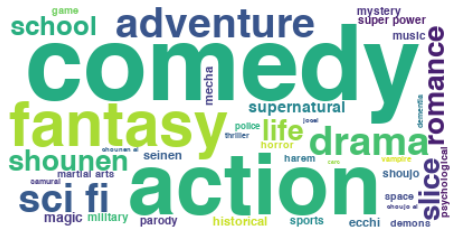

In [57]:
tags = []

for genres in data.genres:
    for genre in genres:
        tags.append(genre)
        
random.shuffle(tags)        

tagString = ' '.join(tags)

rcParams['figure.figsize'] = 8,8
wordcould = WordCloud(font_path='../utils/Helvetica-Bold-Font.ttf', background_color="white").generate(tagString)

plt.imshow(wordcould, interpolation='bilinear')
plt.axis('off')
plt.show()

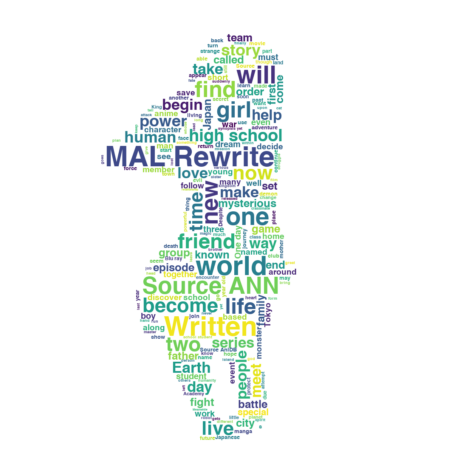

In [39]:
tags = []

for genres in data.description:
    list = genres.replace('[','').replace(']','').replace('\'','')
    for tag in list.split(', '):
        tags.append(tag)
        
random.shuffle(tags)        

tagString = ' '.join(tags)

rcParams['figure.figsize'] = 15,8
mask = np.array(Image.open("../utils/mask2.png"))
wordcould = WordCloud(font_path='../utils/Helvetica-Bold-Font.ttf', background_color="white", mask=mask).generate(tagString)



plt.imshow(wordcould, interpolation='bilinear')
plt.axis('off')
plt.show()

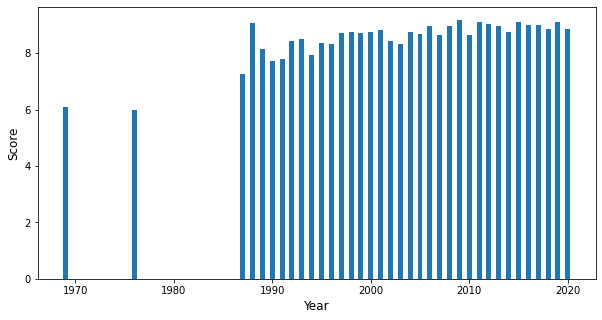

In [13]:
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(data.releaseDate.map(lambda x: x.year), data.score, width = 0.5)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.show()

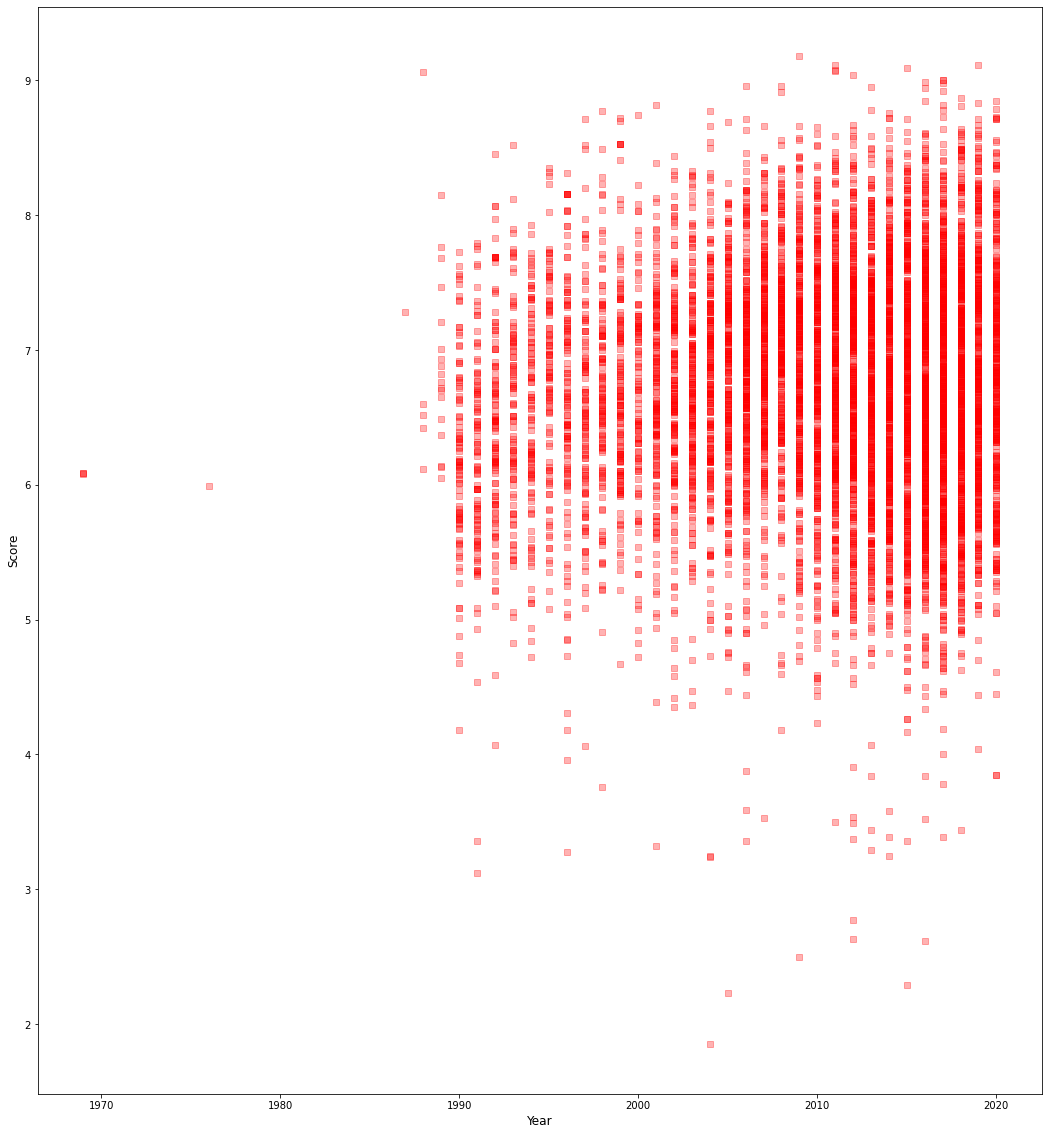

In [14]:
fig, ax = plt.subplots(figsize=(18, 20))

ax.scatter(data.releaseDate.map(lambda x: x.year), data.score,marker="s",alpha=0.3,color='red')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.show()

In [15]:
yearDf = data[data.releaseDate>=datetime(1990, 1,1)].groupby(pd.Grouper(key='releaseDate',freq='Y')).agg(
    year=('releaseDate', lambda x: x.iloc[0].year),
    count=( 'name', 'count'),
    mean=( 'score', 'mean'),
    maxScore=( 'score', 'max'),
    minScore=( 'score', 'min'),
)
yearDf.dropna(inplace=True)
#yearDf.set_index('year', inplace=True)

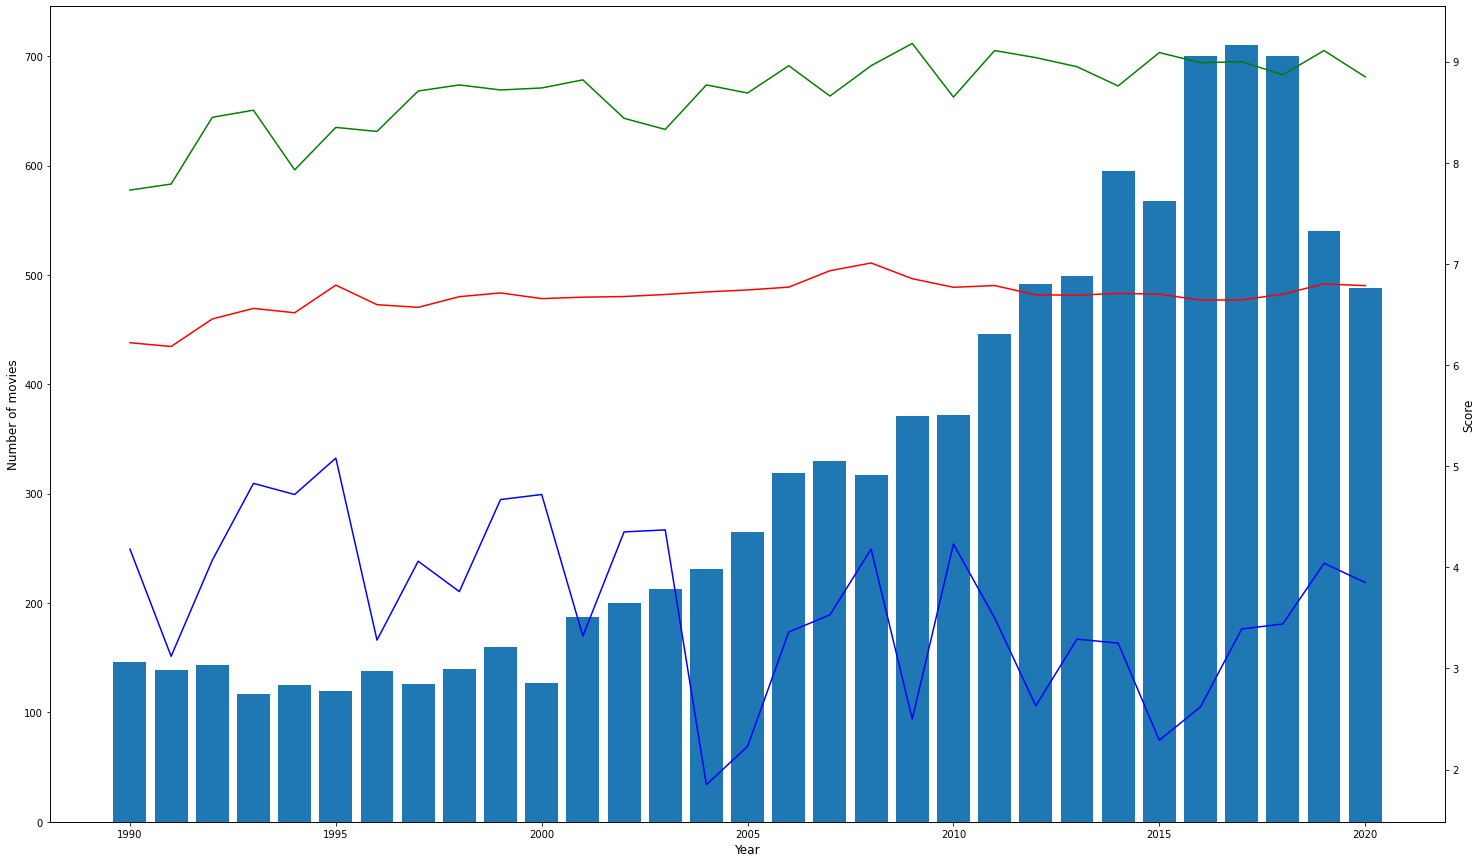

In [16]:
fig = plt.figure(figsize = (25, 15))
 
# # creating the bar plot
# yearDf['count'].plot(kind='bar')
# yearDf[['mean','maxScore','minScore']].plot(color='red', secondary_y=True)

# plt.show()

plt.bar(yearDf['year'], yearDf['count'])
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of movies', fontsize=12)

# x = np.linspace(0, N)
# y = np.sin(x)
axes2 = plt.twinx()
axes2.plot(yearDf['year'], yearDf['mean'], color='red')
axes2.plot(yearDf['year'], yearDf['maxScore'], color='green')
axes2.plot(yearDf['year'], yearDf['minScore'], color='blue')
axes2.set_ylabel("Score", fontsize=12)

plt.show()